In [59]:
%matplotlib inline

import glob
import os

from IPython.core.display import HTML, Image
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn2
import numpy as np
from Bio import SeqIO
import pandas as pd
import scipy
import seaborn as sns
from scipy.stats import hypergeom
from scipy.stats import ks_2samp

from gscripts.general import region_helpers
from gscripts.general import dataviz

img_dir = "/home/gpratt/Dropbox/random_figure/"

In [28]:
datasets = ["fus", 'taf15', 'tdp43', 'fus_taf15', 'taf15_tdp43', 'R521G', 'T198C',]
rbp_colors = dict(zip(datasets, sns.color_palette("bright", len(datasets))))


rbp_colors = {"fus": '#43A247',
             "FUS": '#43A247',
             'taf15': '#DB1D3D',
             'TAF15': '#DB1D3D',
             'tdp43': '#712878',
             'TDP43': '#712878',
             'fus_taf15': 'y',
             'taf15_tdp43': 'k',
             'R521G': 'c', 
             'T198C': 'c',
             'EWS' : 'g',
              'sALS': 'c',
             'ctrl': (0.90311419262605563, 0.54185316071790801, 0.76495195557089413)}


rbp_names = {"fus": 'FUS',
              'taf15': 'TAF15',
              'tdp43': 'TDP43',
              'fus_taf15': 'FUS TAF15',
              'taf15_tdp43': 'TAF15 TDP43',
             'sALS': "sALS",}

In [6]:
gene_id_to_name = region_helpers.gene_id_to_name("/projects/ps-yeolab/genomes/hg19/gencode.v17.annotation.gtf.db")
gene_id_to_type = region_helpers.gene_id_to_type("/projects/ps-yeolab/genomes/hg19/gencode.v17.annotation.gtf.db")

name_to_gene_id = {value: key for key, value in gene_id_to_name.items()}

In [11]:
sALS = pd.read_csv("/home/gpratt/Dropbox/TAF15/Data/sALS/sALS.csv", index_col=0)
sALS.index.names = ["gene_id"]
sALS['gene_name'] = [gene_id_to_name[gene_id] for gene_id in sALS.index]

new_index = []
for index in sALS.index:
    new_index.append(['mn', 'sALS', index])
sALS.index = pd.MultiIndex.from_tuples(new_index)

cashe = {'G298S': 'tdp', 'N352S': 'tdp', 'R521G': 'fus', 'T198C': 'fus'}

ips_knockdowns = pd.concat({os.path.basename(rbp).split(".")[0]: pd.read_csv(rbp, index_col=0) for rbp in glob.glob("/home/gpratt/Dropbox/TAF15/Data/anthony_rnaseq/deseq/*")})
ips_knockdowns['gene_names'] = [gene_id_to_name[gene_id] for gene_id in ips_knockdowns.index.get_level_values(level=1)]

results = []
for item in ips_knockdowns.index:
    gene_id = item[1]
    mutation = item[0].upper()
    rbp = cashe[mutation]
    
    results.append([mutation, rbp, gene_id])
    
ips_knockdowns.index = pd.MultiIndex.from_tuples(results, names=["rbp", 'mutation', "gene"])
ips_knockdowns = ips_knockdowns.sortlevel()

In [53]:
all_knockdowns = pd.concat([ips_knockdowns, sALS])
all_knockdowns["gene_name"] = [gene_id_to_name[gene_id] for gene_id in all_knockdowns.index.get_level_values(level=2)]
all_knockdowns.index.names = ['cell_type', 'rbp', 'gene_id']
all_knockdowns = all_knockdowns.drop(["ews", "hur", "tia1", "hnrnpa2b1"], level="rbp")
# all_knockdowns = all_knockdowns.drop(["N352S", "T198C", "G298S"], level="cell_type")

significant_all_knockdowns = all_knockdowns[(all_knockdowns.padj <= .05) & (abs(all_knockdowns.log2FoldChange) > np.log2(1.5))]
significant_all_upregulated = significant_all_knockdowns[significant_all_knockdowns.log2FoldChange > 0]
significant_all_downregulated = significant_all_knockdowns[significant_all_knockdowns.log2FoldChange < 0]

coding_all_knockdowns = all_knockdowns[[gene_id_to_type[gene] == 'protein_coding' for gene in all_knockdowns.index.get_level_values(level="gene_id")]]
coding_significant_all_knockdowns = significant_all_knockdowns[[gene_id_to_type[gene] == 'protein_coding' for gene in significant_all_knockdowns.index.get_level_values(level="gene_id")]]
coding_significant_all_upregulated = significant_all_upregulated[[gene_id_to_type[gene] == 'protein_coding' for gene in significant_all_upregulated.index.get_level_values(level="gene_id")]]
coding_significant_all_downregulated = significant_all_downregulated[[gene_id_to_type[gene] == 'protein_coding' for gene in significant_all_downregulated.index.get_level_values(level="gene_id")]]


In [54]:
result = []
for name, df in coding_all_knockdowns.groupby(level=['cell_type', 'rbp']):
    df = df.copy()
    df.index = pd.MultiIndex.from_tuples(np.random.permutation(df.index))
    result.append(df)
    
shuffled_all_knockdowns = pd.concat(result, names=coding_all_knockdowns.index.names)
shuffled_all_knockdowns.index.names = coding_all_knockdowns.index.names

shuffled_significant_all_knockdowns = shuffled_all_knockdowns[(shuffled_all_knockdowns.padj <= .05) & (abs(shuffled_all_knockdowns.log2FoldChange) > np.log2(1.5))]
shuffled_significant_all_upregulated = shuffled_significant_all_knockdowns[shuffled_significant_all_knockdowns.log2FoldChange > 0]
shuffled_significant_all_downregulated = significant_all_knockdowns[significant_all_knockdowns.log2FoldChange < 0]

#shuffled_not_significant_changes = shuffled_all_knockdowns[shuffled_all_knockdowns.padj > .05]
shuffled_not_signficant_sals_all = shuffled_all_knockdowns.ix['mn', 'sALS']

In [55]:
sALS_all = coding_significant_all_knockdowns.ix['mn', 'sALS']
sALS_upregulated = coding_significant_all_upregulated.ix['mn', 'sALS']
sALS_all_all = coding_all_knockdowns.ix['mn', 'sALS']

shuffled_all_sals = shuffled_significant_all_knockdowns.ix['mn', 'sALS']
not_significant_changes = coding_all_knockdowns[coding_all_knockdowns.padj > .05]
not_signficant_sals_all = not_significant_changes.ix['mn', 'sALS']

In [56]:
def plot_regressions(merged_df, shuffled_merged_df, not_significant_merged_df, ax =ax):

        result = count_quadrants(merged_df)
        shuffled_result = count_quadrants(shuffled_merged_df)

        ax.scatter(not_significant_merged_df.log2FoldChange_1, 
                   not_significant_merged_df.log2FoldChange_2, 
                   alpha=.7,
                   s=1, 
                   color='0.75', 
                   rasterized=True
                  )
        
        ax.scatter(merged_df.log2FoldChange_1, merged_df.log2FoldChange_2, alpha=.7, s=1, color='r', label="Real")
        ax.scatter(shuffled_merged_df.log2FoldChange_1, shuffled_merged_df.log2FoldChange_2, alpha=.7, s=1, color='k', label="Shuffled")

        linregress = scipy.stats.linregress(merged_df.log2FoldChange_1, merged_df.log2FoldChange_2)

        ax.axvline(np.log2(1.5), color='k', alpha=.6, linewidth=1)
        ax.axvline(-1 * np.log2(1.5), color='k', alpha=.6, linewidth=1)
        
        ax.axhline(np.log2(1.5), color='k', alpha=.6, linewidth=1)
        ax.axhline(-1 * np.log2(1.5), color='k', alpha=.6, linewidth=1)
        
        ax.text(2.8,1.8, "R = {:.2}\np < {:.2}".format(linregress.rvalue, linregress.pvalue), fontsize=6)
        
        ax.text(-3,-3, "N = {}, {}".format(result["fc_1_down_fc_2_down"], shuffled_result["fc_1_down_fc_2_down"]), fontsize=6)
        ax.text(-3,3, "N = {}, {}".format(result["fc_1_down_fc_2_up"], shuffled_result["fc_1_down_fc_2_up"]), fontsize=6)
        ax.text(3,-3, "N = {}, {}".format(result["fc_1_up_fc_2_down"], shuffled_result["fc_1_up_fc_2_down"]), fontsize=6)
        ax.text(3,3, "N = {}, {}".format(result["fc_1_up_fc_2_up"], shuffled_result["fc_1_up_fc_2_up"]), fontsize=6)

        xlim = ax.get_xlim()
        #ax.plot(xlim, 
        #        (linregress.slope * xlim[0] + linregress.intercept, linregress.slope * xlim[1] + linregress.intercept),
        #       alpha=.7, color=".75")
        [tick.set_fontsize(6) for tick in ax.get_xticklabels()]
        [tick.set_fontsize(6) for tick in ax.get_yticklabels()]
        ax.set_xlim(-5,5)
        ax.set_ylim(-5,5)

        return pd.Series(result), pd.Series(shuffled_result)
def count_quadrants(df):

        return {key: len(value) for key, value in overlapping_gene_quadrants(df).items()}

def overlapping_gene_quadrants(df):
        fc_1_up_fc_2_up = df[(df.log2FoldChange_1 > np.log2(1.5)) & (df.log2FoldChange_2 > np.log2(1.5))]
        fc_1_down_fc_2_down = df[(df.log2FoldChange_1 < -1 * np.log2(1.5)) & (df.log2FoldChange_2 < -1 * np.log2(1.5))]
        fc_1_up_fc_2_down =  df[(df.log2FoldChange_1 > np.log2(1.5)) & (df.log2FoldChange_2 < -1 * np.log2(1.5))]
        fc_1_down_fc_2_up = df[(df.log2FoldChange_1 < -1 * np.log2(1.5)) & (df.log2FoldChange_2 > np.log2(1.5))]
        
        fc_1_up = df[(df.log2FoldChange_1 > np.log2(1.5))]
        fc_2_up = df[(df.log2FoldChange_2 > np.log2(1.5))]
        fc_1_down = df[(df.log2FoldChange_1 < -1 * np.log2(1.5))]
        fc_2_down = df[(df.log2FoldChange_2 < -1 * np.log2(1.5))]
        
        result = { "fc_1_up_fc_2_up": fc_1_up_fc_2_up, 
                "fc_1_down_fc_2_down": fc_1_down_fc_2_down, 
                "fc_1_up_fc_2_down": fc_1_up_fc_2_down, 
                "fc_1_down_fc_2_up": fc_1_down_fc_2_up,
#                 "fc_1_up": fc_1_up, 
#                 "fc_2_up": fc_2_up, 
#                 "fc_1_down": fc_1_down,
#                 "fc_2_down": fc_2_down,
                
            }   
        return result

In [66]:
shuffled_all_knockdowns

baseMean   gene_name gene_names  \
cell_type rbp  gene_id                                                    
G298S     tdp  ENSG00000181733.2      632.075388      TSPAN6     TSPAN6   
               ENSG00000172164.9        0.626324        TNMD       TNMD   
               ENSG00000169213.6      382.026978        DPM1       DPM1   
               ENSG00000255275.3      264.136512       SCYL3      SCYL3   
               ENSG00000087884.10     109.948192    C1orf112   C1orf112   
               ENSG00000213203.2        1.417810         FGR        FGR   
               ENSG00000169155.5        8.192891         CFH        CFH   
               ENSG00000124613.4      551.633362       FUCA2      FUCA2   
               ENSG00000182572.2      527.641217        GCLC       GCLC   
               ENSG00000155026.12     886.330735        NFYA       NFYA   
               ENSG00000124143.6      370.380821       STPG1      STPG1   
               ENSG00000156925.7     1092.650905      NIPAL3     NIPAL3   
               ENSG00000143774.12     792.864370       LAS1L      LAS1L   
               ENSG00000081148.10     344.563620       ENPP4      ENPP4   
               ENSG00000169288.13     355.640051      SEMA3F     SEMA3F   
               ENSG00000148180.11      19.785138        CFTR       CFTR   
               ENSG00000161179.9     1810.703955      ANKIB1     ANKIB1   
               ENSG00000204655.7      117.400193     CYP51A1    CYP51A1   
               ENSG00000141994.11     395.236158       KRIT1      KRIT1   
               ENSG00000181896.7      387.235992       RAD52      RAD52   
               ENSG00000006128.7      768.465406         BAD        BAD   
               ENSG00000203880.6      413.180427        LAP3       LAP3   
               ENSG00000147402.7      366.606076        CD99       CD99   
               ENSG00000215428.2       38.570242      HS3ST1     HS3ST1   
               ENSG00000140107.10       0.000000        ABP1       ABP1   
               ENSG00000268465.1        2.028590       WNT16      WNT16   
               ENSG00000006015.13    1015.550960       HECW1      HECW1   
               ENSG00000133800.4      405.958020      MAD1L1     MAD1L1   
               ENSG00000136869.13    1628.032564       LASP1      LASP1   
               ENSG00000169918.5      452.521722       SNX11      SNX11   
...                                          ...         ...        ...   
mn        sALS ENSG00000120437.7        0.188961        PRY2        NaN   
               ENSG00000177689.9        0.000000      RBMY1F        NaN   
               ENSG00000131142.9        0.000000      RBMY1J        NaN   
               ENSG00000149599.11       0.188961         PRY        NaN   
               ENSG00000125484.7        0.000000        BPY2        NaN   
               ENSG00000167723.10       1.496924        DAZ1        NaN   
               ENSG00000167759.8        0.899843        DAZ2        NaN   
               ENSG00000099783.7        0.188961       PRYP3        NaN   
               ENSG00000176753.3        0.000000  AC016752.1        NaN   
               ENSG00000105771.9        0.047240       CDY1B        NaN   
               ENSG00000109501.9        0.000000       BPY2B        NaN   
               ENSG00000198792.7        0.899843        DAZ3        NaN   
               ENSG00000249992.1        1.198383        DAZ4        NaN   
               ENSG00000138798.7        0.000000       BPY2C        NaN   
               ENSG00000247121.2        0.047240        CDY1        NaN   
               ENSG00000196990.4        0.000000  AC007965.1        NaN   
               ENSG00000183091.15       0.188961       PRYP4        NaN   
               ENSG00000078725.8   112174.276513      MT-ND1        NaN   
               ENSG00000080823.17  238648.901907      MT-ND2        NaN   
               ENSG00000185565.6   460477.809884      MT-CO1        NaN   
               ENSG00000187695.6   195719.618983      MT-CO2     

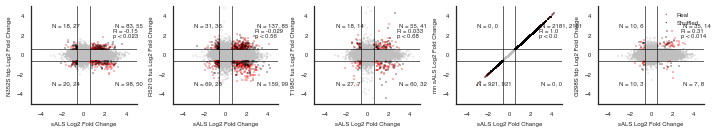

In [79]:
row_num = 1
col_num = 5

real_result = {}
shuffled_result = {}
with dataviz.Figure(os.path.join(img_dir, "significant_regulation_ron.svg"), figsize=(col_num * 2.0, row_num * 2.0)) as fig:
    overlapping_mn_kds = coding_significant_all_knockdowns.groupby(level=["cell_type", 'rbp'])
    for x, (name, df) in enumerate(overlapping_mn_kds):
        ax = fig.add_subplot(row_num, col_num, x)

        merged_df = sALS_all.join(df, lsuffix="_1", rsuffix="_2")
        shuffled_merged_df = shuffled_all_sals.join(shuffled_significant_all_knockdowns.ix[name], lsuffix="_1", rsuffix="_2")

        not_significant_merged_df = sALS_all_all.join(all_knockdowns.ix[name], lsuffix="_1", rsuffix="_2")
        not_significant_merged_df = not_significant_merged_df[(np.abs(not_significant_merged_df.log2FoldChange_1) < np.log2(1.5)) |  (np.abs(not_significant_merged_df.log2FoldChange_2) < np.log2(1.5))]

        real_result[name], shuffled_result[name] = plot_regressions(merged_df, shuffled_merged_df, not_significant_merged_df, ax=ax)
        
        if ax.is_last_col() and ax.is_first_row():
            ax.legend(loc=0, fontsize=6)
        sns.despine(ax=ax)
        if ax.is_last_row():
            ax.set_xlabel("sALS Log2 Fold Change", fontsize=6)
            
        ax.set_ylabel("{} Log2 Fold Change".format(" ".join(name)), fontsize=6)
        
real_result = pd.DataFrame(real_result)
shuffled_result = pd.DataFrame(shuffled_result)

In [80]:
real_result

,G298S,N352S,R521G,T198C,mn
,tdp,tdp,fus,fus,sALS
fc_1_down_fc_2_down,10,20,69,27,921
fc_1_down_fc_2_up,10,18,31,18,0
fc_1_up_fc_2_down,7,98,159,60,0
fc_1_up_fc_2_up,35,83,137,55,2181


In [ ]:
for name, count in real_df.sum().iteritems():
    expected = count * pairwise_probablity(fraction_regulated.ix['mn', 'sALS'], fraction_regulated.ix['mn', name])
    result = scipy.stats.chisquare(r521g_real_result[name].values, expected.values)
    print name, result.pvalue